# **IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT**

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}



In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

## **GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS**

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm

In [ ]:
import torch
import torch.nn as nn

# ===============================
# DummyGPTModel — A minimal GPT-like model structure
# ===============================
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        """
        Initialize the DummyGPTModel using the given configuration dictionary.

        Args:
            cfg (dict): A configuration dictionary containing model hyperparameters:
                - "vocab_size": Size of the token vocabulary.
                - "emb_dim": Dimensionality of token and positional embeddings.
                - "context_length": Maximum sequence length (number of positions).
                - "drop_rate": Dropout probability for embeddings.
                - "n_layers": Number of Transformer blocks.
        """
        super().__init__()

        # Embedding layer for tokens (converts token IDs into embedding vectors)
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        # Embedding layer for positional encodings (represents token position in sequence)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # Dropout layer applied after combining token and positional embeddings
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # A stack of "Transformer blocks" — here they are dummy placeholders
        # Each block would normally contain self-attention + feedforward layers.
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # A final normalization layer (placeholder)
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        # Output layer that maps from embedding dimension to vocabulary size
        # Used to generate logits for each token in the vocabulary.
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        """
        Forward pass of the DummyGPTModel.

        Args:
            in_idx (torch.Tensor): Tensor of token indices with shape (batch_size, seq_len)

        Returns:
            logits (torch.Tensor): Output predictions (unnormalized probabilities)
                                   of shape (batch_size, seq_len, vocab_size)
        """
        # Extract batch size and sequence length from input
        batch_size, seq_len = in_idx.shape

        # Token embeddings: Convert token IDs to embedding vectors
        tok_embeds = self.tok_emb(in_idx)

        # Positional embeddings: Create embeddings for each position in the sequence
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # Combine token embeddings with positional embeddings (broadcasting adds position info)
        x = tok_embeds + pos_embeds

        # Apply dropout regularization
        x = self.drop_emb(x)

        # Pass through a series of Transformer blocks (here, they do nothing)
        x = self.trf_blocks(x)

        # Apply final normalization (dummy layer)
        x = self.final_norm(x)

        # Compute output logits for each token position
        logits = self.out_head(x)

        return logits


# ===============================
# DummyTransformerBlock — Placeholder for a real Transformer block
# ===============================
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        Placeholder Transformer block.
        In a real model, this would include:
            - Multi-head self-attention
            - Feed-forward neural network
            - Layer normalization
            - Residual connections
        """
        super().__init__()
        # No real operations here — just a placeholder for architecture structure

    def forward(self, x):
        """
        Forward pass through the dummy Transformer block.
        Simply returns the input tensor unchanged.
        """
        return x


# ===============================
# DummyLayerNorm — Placeholder for Layer Normalization
# ===============================
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        """
        Dummy LayerNorm initialization.
        In a real implementation, this would compute normalization over features.

        Args:
            normalized_shape (int): Number of features in the input tensor to normalize.
            eps (float): Small constant added to denominator for numerical stability.
        """
        super().__init__()
        # Placeholder — does not actually normalize the input

    def forward(self, x):
        """
        Forward pass through the dummy normalization layer.
        Simply returns the input tensor unchanged.
        """
        return x


The DummyGPTModel class in this code defines a simplified version of a GPT-like model using
PyTorch's neural network module (nn.Module).

The model architecture in the
DummyGPTModel class consists of token and positional embeddings, dropout, a series of
transformer blocks (DummyTransformerBlock), a final layer normalization
(DummyLayerNorm), and a linear output layer (out_head).

The configuration is passed in via
a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.

The forward method describes the data flow through the model: it computes token and
positional embeddings for the input indices, applies dropout, processes the data through
the transformer blocks, applies normalization, and finally produces logits with the linear
output layer.

The code above is already functional, as we will see later in this section after we prepare
the input data.

However, for now, note in the code above that we have used placeholders
(DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer
normalization, which we will develop in later sections


Next, we will prepare the input data and initialize a new GPT model to illustrate its
usage.

### **STEP 1: TOKENIZATION**

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### **STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL**

In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two rows corresponding to the two text samples. Each text sample
consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of
the tokenizer's vocabulary.


The embedding has 50,257 dimensions because each of these dimensions refers to a
unique token in the vocabulary. At the end of this chapter, when we implement the
postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs,
which we can then decode into words.

Now that we have taken a top-down look at the GPT architecture and its in- and outputs,
we will code the individual placeholders in the upcoming sections, starting with the real
layer normalization class that will replace the DummyLayerNorm in the previous code.

## **GPT ARCHITECTURE PART 2: LAYER NORMALIZATION**

#### **Explanation with a simple example**

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


The neural network layer we have coded consists of a Linear layer followed by a non-linear
activation function, ReLU (short for Rectified Linear Unit), which is a standard activation
function in neural networks.

If you are unfamiliar with ReLU, it simply thresholds negative
inputs to 0, ensuring that a layer outputs only positive values, which explains why the
resulting layer output does not contain any negative values.

(Note that we will use another,
more sophisticated activation function in GPT, which we will introduce in the next section).


Before we apply layer normalization to these outputs, let's examine the mean and
variance

In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


The first row in the mean tensor above contains the mean value for the first input row, and
the second output row contains the mean for the second input row.

Using keepdim=True in operations like mean or variance calculation ensures that the
output tensor retains the same number of dimensions as the input tensor, even though the
operation reduces the tensor along the dimension specified via dim.

For instance, without
keepdim=True, the returned mean tensor would be a 2-dimensional vector [0.1324,
0.2170] instead of a 2×1-dimensional matrix [[0.1324], [0.2170]].


For a 2D tensor (like a matrix), using dim=-1 for operations such as
mean or variance calculation is the same as using dim=1.

This is because -1 refers to the
tensor's last dimension, which corresponds to the columns in a 2D tensor.

Later, when
adding layer normalization to the GPT model, which produces 3D tensors with shape
[batch_size, num_tokens, embedding_size], we can still use dim=-1 for normalization
across the last dimension, avoiding a change from dim=1 to dim=2.

Next, let us apply layer normalization to the layer outputs we obtained earlier. The
operation consists of subtracting the mean and dividing by the square root of the variance
(also known as standard deviation)

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Note that the value 2.9802e-08 in the output tensor is the scientific notation for 2.9802 ×
10-8, which is 0.0000000298 in decimal form. This value is very close to 0, but it is not
exactly 0 due to small numerical errors that can accumulate because of the finite precision
with which computers represent numbers.

To improve readability, we can also turn off the scientific notation when printing tensor
values by setting sci_mode to False

In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Let's now encapsulate this process in a PyTorch module that we can use in the GPT
model later

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim).

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization.

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task.

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

### **A small note on biased variance**

In our variance calculation method, we have opted for an implementation detail by
setting unbiased=False.

For those curious about what this means, in the variance
calculation, we divide by the number of inputs n in the variance formula.

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in
the denominator to adjust for bias in sample variance estimation.

This decision results in a so-called biased estimate of the variance.

For large-scale language
models (LLMs), where the embedding dimension n is significantly large, the
difference between using n and n-1 is practically negligible.

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it
reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.


Let's now try the LayerNorm module in practice and apply it to the batch input

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


As we can see based on the results, the layer normalization code works as expected and
normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1

### **Why Normalization does not do negative effect?**

The Core Question

> “Layer normalization changes the output values numerically, and two same vectors can have different values after normalization at different times.
> Why doesn’t this negatively affect training globally?”

**What really happens when we normalize**

When you apply Layer Normalization, you compute
$$\text{LN}(x) = \gamma \cdot \frac{x - \mu}{\sigma + \epsilon} + \beta$$

* Here, $ \mu $ and $ \sigma $ are computed for each input sample separately.
* So yes — even if the same input vector appears at different training steps,
  its surrounding network context (weights before it, gradients, etc.) may have changed
   → which means $ x $, $\mu $, and $ \sigma $ will differ slightly.

Hence, the *numerical values* after normalization can differ over time.

But that’s *not a bug* — it’s part of what helps the model train.



**Why that’s not harmful (and actually helpful)**

Even though normalization changes numbers dynamically, training doesn’t get confused because

1. The model learns to adapt to normalization

> - LayerNorm has trainable parameters γ (scale) and β (bias).They let the network re-scale and re-shift normalized values as needed.
> - So if the network needs certain magnitude or offset to represent information,γ and β will learn to bring that back.
> - Normalization doesn’t destroy information — it just stabilizes it, then allows the network to “recover” whatever scale/offset it wants.

2. Normalization keeps the "direction" of information consistent

> - When you normalize, you change the magnitude of the activations but keep their relative direction in feature space.
> - In deep learning, the relative direction (how features vary together) is what carries information, not the absolute scale.
> - So even if the numeric values change, the pattern of information remains intact — and that’s what the next layer learns from.

3. It makes optimization more stable globally

> Without normalization, during backpropagation
> - Activations can explode or vanish (causing unstable gradients)
> - Each layer can shift its output distribution unpredictably (called *internal covariate shift*).
> - LayerNorm ensures that every layer sees inputs that are roughly **centered and scaled**, regardless of how other layers change.
> - This stability lets optimizers (like Adam) make consistent updates even when earlier weights shift slightly.
> - So even though the *numbers* change locally, the overall learning process stays stable globally.

4. Global model behavior depends on *relative changes*, not absolute values

> - Let’s think in terms of training dynamics
> - Suppose at time step T₁, a vector $ x_1 $ → normalized → $ y_1 $
> - At time step T₂, same vector (but slightly different due to learned weights) → normalized → $ y_2 $
> - Even though $ y_1 \ne y_2 $, the *entire model* (all layers, parameters, gradients) is changing together in a **coordinated way**.
> - Training doesn’t require outputs to be numerically stable — only that the optimization process is *consistent* and *gradient-friendly*.
> - The model doesn’t rely on *exact numbers*, but rather on how they change relative to the loss landscape.



**Analogy**

>Think of LayerNorm like a **thermostat** in a large system.
>
> - Even though the exact temperature readings (values) fluctuate,
> - The thermostat keeps things in a healthy range — preventing overheat or freeze,
> - So the overall system (the model) can keep working efficiently.
> - The local variations don’t harm the global function — they help maintain global *stability*.

**In short**

> LayerNorm changes local values dynamically,
> but globally it **preserves representational meaning, stabilizes optimization, and keeps gradients healthy.**
> That’s why it *helps* rather than hurts training.

### **Batch Normalization vs Layer Normalization**



| Feature                              | **Batch Normalization (BatchNorm)**                                                                | **Layer Normalization (LayerNorm)**                                                             |
| ------------------------------------ | -------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Normalization Scope**              | Across the **batch dimension** (mean and variance are computed for each feature across the batch). | Across the **feature dimension** (mean and variance are computed for each sample individually). |
| **Used in**                          | Common in **CNNs** and feedforward networks.                                                       | Common in **Transformers**, **RNNs**, and **language models**.                                  |
| **Dependency on Batch Size**         | Depends on batch statistics — smaller batches can make training unstable.                          | Independent of batch size — works well even with batch size = 1.                                |
| **When statistics are computed**     | During **training**, uses batch stats; during **inference**, uses running (moving average) stats.  | Uses **current input only**, both during training and inference.                                |
| **Computation axis**                 | Normalizes each feature across all samples in the batch.                                           | Normalizes all features within a single sample.                                                 |
| **Formula**                          | ( \hat{x} = \frac{x - \mu_{batch}}{\sigma_{batch} + \epsilon} )                                    | ( \hat{x} = \frac{x - \mu_{layer}}{\sigma_{layer} + \epsilon} )                                 |
| **Best suited for**                  | Vision models (CNNs), large batches.                                                               | Sequence models (Transformers, NLP), small batches, or variable-length inputs.                  |
| **Typical location in architecture** | After linear/convolutional layers.                                                                 | After linear or attention layers.                                                               |
| **Training Stability**               | Can fluctuate with batch composition.                                                              | More stable, since normalization is per sample.                                                 |
| **Example Use**                      | ResNet, EfficientNet                                                                               | GPT, BERT, Transformer                                                                          |

**Simple Intuition**

* **BatchNorm:** “I’ll normalize each feature across the whole mini-batch.”
* **LayerNorm:** “I’ll normalize all features within each training example.”


## **GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION**

Let's implement the GELU activation function approximation used by GPT-2

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

To get an idea of what this GELU function looks like and how it compares to the ReLU
function, let's plot these functions side by side

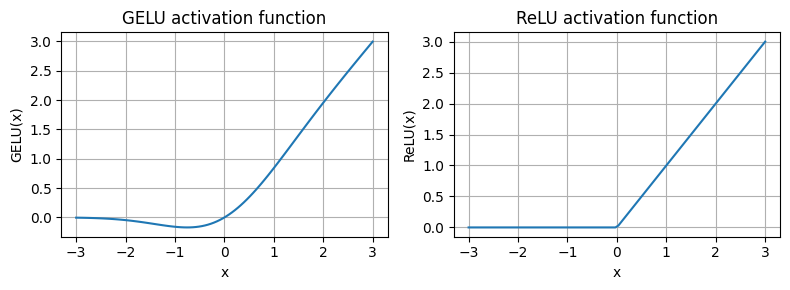

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


As we can see in the resulting plot, ReLU is a piecewise linear function that
outputs the input directly if it is positive; otherwise, it outputs zero.

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.


The smoothness of GELU, as shown in the above figure, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters.

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures.

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values.

This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.

Next, let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
print(GPT_CONFIG_124M["emb_dim"])


768


As we can see in the preceding code, the FeedForward module is a small neural network
consisting of two Linear layers and a GELU activation function.

In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding
size of 768 each via the GPT_CONFIG_124M dictionary where GPT_CONFIG_124M["emb_dim"]
= 768.


Let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The FeedForward module we implemented in this section plays a crucial role in enhancing
the model's ability to learn from and generalize the data.


Although the input and output dimensions of this module are the same, it internally expands the embedding dimension
into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to
the original dimension with the second linear transformation.

Such a design allows for the
exploration of a richer representation space.

Moreover, the uniformity in input and output dimensions simplifies the architecture by
enabling the stacking of multiple layers, as we will do later, without the need to adjust
dimensions between them, thus making the model more scalable.

## **GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS**

Let us see how we can add shortcut connections to the forward method

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


The code implements a deep neural network with 5 layers, each consisting of a Linear
layer and a GELU activation function.

In the forward pass, we iteratively pass the input
through the layers and optionally add the shortcut connections  if
the self.use_shortcut attribute is set to True.

Let's use this code to first initialize a neural network without shortcut connections. Here,
each layer will be initialized such that it accepts an example with 3 input values and returns
3 output values. The last layer returns a single output value

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

Next, we implement a function that computes the gradients in the the model's backward
pass

In [ ]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In the preceding code, we specify a loss function that computes how close the model output
and a user-specified target (here, for simplicity, the value 0) are.

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model.

We can iterate through the weight parameters via model.named_parameters().

Suppose we have a 3×3 weight parameter matrix for a given layer.

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to
obtain a single gradient value per layer to compare the gradients between layers more
easily.

In short, the .backward() method is a convenient method in PyTorch that computes loss
gradients, which are required during model training, without implementing the math for the
gradient calculation ourselves, thereby making working with deep neural networks much
more accessible.

Let's now use the `print_gradients` function and apply it to the model without skip
connections

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.

Let's now instantiate a model with skip connections and see how it compares

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


As we can see, based on the output, the last layer (layers.4) still has a larger gradient
than the other layers.

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.

In conclusion, shortcut connections are important for overcoming the limitations posed
by the vanishing gradient problem in deep neural networks.

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model

## **GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK**

Let us code a transformer block as follows

Step 1: Shortcut connection for attention block

Step 2:  Shortcut connection for feed forward block

Step 3: Add the original input back

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        A single Transformer block that combines:
        1. Multi-Head Self-Attention
        2. Feed-Forward Network
        3. Layer Normalization
        4. Residual (skip) connections
        5. Dropout regularization

        Args:
            cfg (dict): Configuration dictionary containing:
                - emb_dim: Embedding dimension (input/output feature size)
                - context_length: Maximum number of tokens (sequence length)
                - n_heads: Number of attention heads
                - drop_rate: Dropout rate
                - qkv_bias: Whether to use bias in query/key/value projections
        """
        super().__init__()

        # Multi-Head Self-Attention layer
        # This lets each token "attend" to (look at) other tokens in the sequence
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],            # Input embedding dimension
            d_out=cfg["emb_dim"],           # Output dimension (same as input)
            context_length=cfg["context_length"],  # Sequence length (number of tokens)
            num_heads=cfg["n_heads"],       # Number of parallel attention heads
            dropout=cfg["drop_rate"],       # Dropout applied inside attention
            qkv_bias=cfg["qkv_bias"]        # Whether to use bias terms in Q, K, V projections
        )

        # Feed-forward sublayer (position-wise fully connected network)
        # Usually consists of two linear layers with a GELU/ReLU activation
        self.ff = FeedForward(cfg)

        # First Layer Normalization (applied before attention)
        self.norm1 = LayerNorm(cfg["emb_dim"])

        # Second Layer Normalization (applied before feed-forward)
        self.norm2 = LayerNorm(cfg["emb_dim"])

        # Dropout applied to residual (shortcut) connections to prevent overfitting
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        """
        Forward pass through the Transformer block.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_tokens, emb_dim]

        Returns:
            torch.Tensor: Output tensor of the same shape as input
        """

        # ==============================
        # 1️⃣ Attention Sub-Layer
        # ==============================

        # Save input as shortcut (for residual connection)
        shortcut = x

        # Apply layer normalization before attention
        x = self.norm1(x)

        # Apply multi-head self-attention
        # Each token attends to other tokens and aggregates contextual info
        x = self.att(x)  # Shape: [batch_size, num_tokens, emb_dim]

        # Apply dropout to attention output for regularization
        x = self.drop_shortcut(x)

        # Add the original input (residual connection)
        # Helps prevent vanishing gradients and preserves original information
        x = x + shortcut

        # ==============================
        # 2️⃣ Feed-Forward Sub-Layer
        # ==============================

        # Save input again for another residual connection
        shortcut = x

        # Apply layer normalization before feed-forward network
        x = self.norm2(x)

        # Pass through the feed-forward network
        x = self.ff(x)

        # Apply dropout to feed-forward output
        x = self.drop_shortcut(x)

        # Add the shortcut again (residual connection)
        x = x + shortcut

        # ==============================
        # 3️⃣ Output
        # ==============================

        # Return the transformed tensor (same shape as input)
        return x


The given code defines a TransformerBlock class in PyTorch that includes a multi-head
attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward),
both configured based on a provided configuration dictionary (cfg), such as
GPT_CONFIG_124M

Layer normalization (LayerNorm) is applied before each of these two components, and
dropout is applied after them to regularize the model and prevent overfitting.

This is also known as Pre-LayerNorm.

Older architectures, such as the original transformer model,
applied layer normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics.

The class also implements the forward pass, where each component is followed by a
shortcut connection that adds the input of the block to its output. This critical feature helps
gradients flow through the network during training and improves the learning of deep
models

Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer
block and feed it some sample data

Create sample input of shape [batch_size, num_tokens, emb_dim]

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


As we can see from the code output, the transformer block maintains the input dimensions
in its output, indicating that the transformer architecture processes sequences of data
without altering their shape throughout the network.

  
The preservation of shape throughout the transformer block architecture is not incidental
but a crucial aspect of its design.

This design enables its effective application across a wide
range of sequence-to-sequence tasks, where each output vector directly corresponds to an
input vector, maintaining a one-to-one relationship.

However, the output is a context vector
that encapsulates information from the entire input sequence.

This means that while the physical dimensions of the sequence (length and feature size)
remain unchanged as it passes through the transformer block, the content of each output
vector is re-encoded to integrate contextual information from across the entire input
sequence.

## **GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION**

The device setting will allow us to train the model on a CPU or GPU, depending on which device the input
data sits

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        """
        GPTModel — A simplified Generative Pretrained Transformer (GPT)-style model.

        This model processes sequences of token IDs and predicts the next token
        in a sequence using a stack of Transformer blocks.

        Args:
            cfg (dict): Configuration dictionary containing:
                - vocab_size: Total number of unique tokens (vocabulary size)
                - emb_dim: Embedding dimension (size of each token vector)
                - context_length: Maximum number of tokens in one input sequence
                - drop_rate: Dropout probability (for regularization)
                - n_layers: Number of stacked Transformer blocks
        """
        super().__init__()

        # ===============================
        # 1️⃣ Embedding Layers
        # ===============================

        # Token embedding: Converts token indices into continuous embedding vectors
        # Shape after embedding → [batch_size, seq_len, emb_dim]
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        # Positional embedding: Adds information about token positions in the sequence
        # Each position (0, 1, 2, … context_length-1) has its own embedding vector
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # Dropout layer for regularization applied to embeddings
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # ===============================
        # 2️⃣ Transformer Blocks
        # ===============================

        # Stack of multiple Transformer blocks (each block = attention + feedforward)
        # The '*' operator unpacks the list of blocks inside nn.Sequential
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # ===============================
        # 3️⃣ Final Layers
        # ===============================

        # Layer normalization applied after all transformer layers
        # This helps stabilize the output representations
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # Linear layer (output head): Maps each token’s embedding
        # to a vector of size 'vocab_size' — i.e., prediction logits for each token
        # No bias term because embedding and output projections often share weights
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        """
        Forward pass through the GPT model.

        Args:
            in_idx (torch.Tensor): Input tensor of token indices,
                                   shape [batch_size, seq_len]

        Returns:
            logits (torch.Tensor): Predicted unnormalized probabilities for each token,
                                   shape [batch_size, seq_len, vocab_size]
        """
        # Extract batch size and sequence length from the input tensor
        batch_size, seq_len = in_idx.shape

        # ===============================
        # 1️⃣ Token + Positional Embeddings
        # ===============================

        # Get token embeddings for each input token ID
        tok_embeds = self.tok_emb(in_idx)  # Shape: [batch_size, seq_len, emb_dim]

        # Create position indices (0 to seq_len-1) and get their embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # Combine token embeddings with position embeddings
        # Adds positional information to each token representation
        x = tok_embeds + pos_embeds  # Shape: [batch_size, seq_len, emb_dim]

        # Apply dropout to prevent overfitting
        x = self.drop_emb(x)

        # ===============================
        # 2️⃣ Transformer Encoder Blocks
        # ===============================

        # Pass embeddings through the stack of Transformer blocks
        # Each block performs self-attention + feed-forward processing
        x = self.trf_blocks(x)

        # Apply final layer normalization
        x = self.final_norm(x)

        # ===============================
        # 3️⃣ Output Projection
        # ===============================

        # Project each embedding vector to vocabulary logits
        # This produces predictions for the next token at each position
        logits = self.out_head(x)  # Shape: [batch_size, seq_len, vocab_size]

        # Return logits (to be used with cross-entropy loss during training)
        return logits

  
The `__init__` constructor of this GPTModel class initializes the token and positional
embedding layers using the configurations passed in via a Python dictionary, cfg.

These
embedding layers are responsible for converting input token indices into dense vectors and
adding positional information.

   
Next, the `__init__` method creates a sequential stack of TransformerBlock modules
equal to the number of layers specified in cfg.

Following the transformer blocks, a
LayerNorm layer is applied, standardizing the outputs from the transformer blocks to
stabilize the learning process.

Finally, a linear output head without bias is defined, which
projects the transformer's output into the vocabulary space of the tokenizer to generate
logits for each token in the vocabulary.

   
The forward method takes a batch of input token indices, computes their embeddings,
applies the positional embeddings, passes the sequence through the transformer blocks,
normalizes the final output, and then computes the logits, representing the next token's
unnormalized probabilities. We will convert these logits into tokens and text outputs in the
next section.

Let's now initialize the 124 million parameter GPT model using the GPT_CONFIG_124M
dictionary we pass into the cfg parameter and feed it with the batch text input we created
at the beginning of this chapter

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.

Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?

The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer.

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


As we can see based on the print outputs, the weight tensors for both these layers have the
same shape

The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying

In [ ]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.

   
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object

In [ ]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


   
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

   
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

## **GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS**

Let us implement the token-generation process as follows

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

   
In the preceeding code, the generate_text_simple function, we use a softmax function to
convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax.

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs.

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the
same position in the logit tensor.

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results.

However, we coded the conversion to
illustrate the full process of transforming logits to probabilities, which can add additional
intuition, such as that the model generates the most likely next token, which is known as
greedy decoding.

    
In the next chapter, when we will implement the GPT training code, we will also
introduce additional sampling techniques where we modify the softmax outputs such that
the model doesn't always select the most likely token, which introduces variability and
creativity in the generated text.

Let's now try out the generate_text_simple function with the "Hello, I am" context
as model input

First, we encode the input context into token IDs:

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into `.eval()` mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor

We disable dropout since we are not training the model

In [ ]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


Using the .decode method of the tokenizer, we can convert the IDs back into text

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text.

What happened?

The reason why the model is unable to produce coherent text is that we haven't trained it yet.

So far, we just
implemented the GPT architecture and initialized a GPT model instance with initial random
weights.

# **EVALUATING GENERATIVE TEXT MODELS**

### **GPT Model class we coded earlier**

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### **Using GPT to generate text**

We initialize a GPT model using the code from the previous chapter

In [ ]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

This is so that more readers will be able to follow and execute the code examples on their laptop computer

Next, we use the `generate_text_simple` function from the previous chapter to generate text.

In addition, we define two convenience functions, `text_to_token_ids and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

The next chapters on finetuning LLMs will also introduce additional ways to measure model quality


### **Calculating the text generation loss: cross-entropy and perplexity**

Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows)

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate

Notice that the targets are the inputs shifted by 1 position, as explained in chapter 2 when we implemented the data loader

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets)

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


### **Cross-entropy loss**

The token probabilities corresponding to the target indices are as follows:


In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


We want to maximize all these values, bringing them close to a probability of 1.
    
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

In [ ]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Next, we compute the average log probability:

In [ ]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

In [ ]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### **Perplexity**

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

### **Calculating the training and validation set losses**

We use a relatively small dataset for training the LLM (in fact, only one short story)

The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.
    
We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size.
    
For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars.

So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars



In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

A quick check that the text loaded ok by printing the first and last 100 words

In [ ]:
# First 100 characters
print(text_data[:99])

I had always thought Jack Gisburn rather a cheap genius--though a

good fellow enough--so it was no


In [ ]:
# Last 100 characters
print(text_data[-99:])

and alone, and happen once--but

there's no exterminating our kind of art."

The End of The Verdict


In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20758
Tokens: 5765


With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later).

Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.
    
For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports.

Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position    

In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with.

Llama 2 7B was trained with a batch size of 1024, for example.

An optional check that the data was loaded correctly

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


An optional check that the data was loaded correctly

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 5120
Validation tokens: 512
All tokens: 5632


Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
    
Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.970044708251953
Validation loss: 10.984174728393555


# **TRAINING LOOP FOR THE LLM**

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

The evaluate_model function calculates the loss over the training and
validation set while ensuring the model is in evaluation mode with gradient tracking and
dropout disabled when calculating the loss over the training and validation sets

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training.

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input,
converts it into token IDs, and feeds it to the LLM to generate a text sample using the
generate_text_simple function we used earlier

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW
optimizer and the train_model_simple function we defined earlier.

In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.350, Val loss 9.452
Ep 1 (Step 000005): Train loss 7.784, Val loss 7.938
Every effort moves you                                                  
Ep 2 (Step 000010): Train loss 6.496, Val loss 6.811
Ep 2 (Step 000015): Train loss 5.825, Val loss 6.393
Every effort moves you, the                                                
Ep 3 (Step 000020): Train loss 5.721, Val loss 6.334
Ep 3 (Step 000025): Train loss 5.500, Val loss 6.360
Every effort moves you, and                                                
Ep 4 (Step 000030): Train loss 5.289, Val loss 6.294
Ep 4 (Step 000035): Train loss 5.270, Val loss 6.368
Every effort moves you                              ", and, and I had been.           
Ep 5 (Step 000040): Train loss 5.140, Val loss 6.502
Ep 5 (Step 000045): Train loss 5.131, Val loss 6.384
Every effort moves you                                                  
Ep 6 (Step 000050): Train loss 4.520, Val loss 6.386
Ep 6 (Step 000055): Train loss 4

As we can see, based on the results printed during the training, the training loss improves
drastically, starting with a value of 9.781 and converging to 0.391.

The language skills of
the model have improved quite a lot. In the beginning, the model is only able to append
commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the
word "and".

At the end of the training, it can generate grammatically correct text.

Similar to the training set loss, we can see that the validation loss starts high (9.856)
and decreases during the training.

However, it never becomes as small as the training set
loss and remains at 6.372 after the 10th epoch.

Let's create a simple plot that shows the training and validation set losses side by side

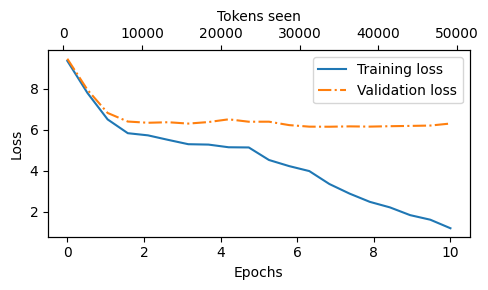

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Both the training and validation losses start to improve for the first
epoch. However, the losses start to diverge past the second epoch.

This divergence and the
fact that the validation loss is much larger than the training loss indicate that the model is
overfitting to the training data.

We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as "quite insensible to the
irony" in the "The Verdict" text file.


This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs.

Usually, it's common to train a model
on a much, much larger dataset for only one epoch.   

## **Notes**

### Optimizers Used in LLM Training

Large Language Models (LLMs) rely on gradient-based optimization, where optimizers adjust billions of parameters to minimize the loss.
The most common optimizers are **Adam** and its improved variants.

| **Optimizer**         | **Description**                                                                                                  | **Used In**                      |
| --------------------- | ---------------------------------------------------------------------------------------------------------------- | -------------------------------- |
| **Adam**              | Adaptive Moment Estimation — combines *momentum* and *RMSProp* ideas to adapt learning rates for each parameter. | BERT, GPT-2                      |
| **AdamW**             | Adam with **decoupled weight decay**, improving generalization and training stability.                           | GPT-3, GPT-4, LLaMA              |
| **Lion**              | Lightweight optimizer using only the **sign of momentum** for updates — faster and more memory-efficient.        | Newer research (Meta, 2023–2024) |
| **Adafactor**         | Memory-efficient Adam variant — factorizes large parameter matrices.                                             | T5, PaLM                         |
| **SGD with Momentum** | Simple and stable, but converges slower in high-dimensional settings.                                            | Smaller or older models          |


**Example: AdamW Update Rule**

> The **AdamW optimizer** is a key improvement over Adam.
> It decouples *weight decay* from the gradient update, improving convergence and avoiding bias in L2 regularization.

**Update Equations**

At iteration (t)

$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$
$$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 $$
$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $$
$$ \hat{v}*t = \frac{v_t}{1 - \beta_2^t} $$
$$ \theta*{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \eta \lambda \theta_t $$



**Explanation of Terms**

| Symbol                   | Meaning                                                       |
| ------------------------ | ------------------------------------------------------------- |
| ( g_t )                  | Gradient of loss with respect to parameters at step (t)       |
| ( m_t )                  | Exponentially decaying average of past gradients (momentum)   |
| ( v_t )                  | Exponentially decaying average of past squared gradients      |
| ( \beta_1, \beta_2 )     | Hyperparameters controlling decay rates (typical: 0.9, 0.999) |
| ( \hat{m}_t, \hat{v}_t ) | Bias-corrected estimates of (m_t) and (v_t)                   |
| ( \eta )                 | Learning rate                                                 |
| ( \lambda )              | Weight decay coefficient (regularization term)                |
| ( \epsilon )             | Small constant for numerical stability                        |



**How It Works Conceptually**

1. **Compute gradient** ( g_t ) of the loss function.
2. **Update moving averages:**

   * ( m_t ): tracks gradient direction (momentum).
   * ( v_t ): tracks gradient magnitude (RMS normalization).
3. **Bias-correct** both to account for initialization effects.
4. **Update parameters:** move opposite to the gradient direction, with adaptive step size.
5. **Apply weight decay:** regularize parameters to prevent overfitting.



### Optimization Challanges

| Challenge                         | Description                                          | Mitigation                                             |
| --------------------------------- | ---------------------------------------------------- | ------------------------------------------------------ |
| **Vanishing/Exploding Gradients** | Gradients become too small/large through deep layers | LayerNorm, residuals, gradient clipping                |
| **Instability in FP16 precision** | Floating point rounding issues                       | Use BF16 or mixed-precision scaling                    |
| **Huge Memory Usage**             | Billions of parameters & optimizer states            | ZeRO optimizer, sharded training                       |
| **Slow Convergence**              | Needs trillions of tokens                            | Adaptive LR, batch normalization, large-batch training |
| **Catastrophic Forgetting**       | During fine-tuning, model forgets pretraining        | Low LR, regularization, LoRA adapters                  |


### **Learning Rate Schedules**

The **learning rate (LR)** controls *how big a step* the optimizer takes when updating weights.
If the step is **too big → unstable / divergence**,
if **too small → slow learning**.

So, instead of keeping it constant, LLMs **change it gradually during training** — this is called a **learning rate schedule**.

---

Common Learning Rate Schedules

| **Schedule**              | **What It Does**                                                                                                       | **How It Helps**                                                    | **Used In**                |
| ------------------------- | ---------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------- | -------------------------- |
| **Warmup + Cosine Decay** | Start with a small LR <br> (warmup), then slowly<br> increase, and finally<br> decrease in a smooth<br> wave-like curve <br>(cosine shape). | Prevents instability at the<br> start and fine-tunes slowly <br>at the end. | GPT, LLaMA                 |
| **Linear Decay**          | Increases LR during<br> warmup, then gradually<br> decreases it linearly to <br>zero.                                              | Simple and stable for<br> most models.                                  | BERT, RoBERTa              |
| **Step Decay**            | Keeps LR constant for<br> a few epochs, then<br> suddenly reduces it<br> (like steps).                                             | Older technique, less smooth.                                       | Early deep learning models |


**Why “Warmup”?**


At the very beginning of training

* The model’s weights are random.
* Gradients (the learning signals) can be **unstable or huge**.

If you start with a large learning rate, these large gradients can **blow up the weights** → training fails.

So, we **“warm up”** by

* starting with a very small learning rate,
* gradually increasing it for the first few thousand steps,
* then switching to a decay schedule.

Think of it like

> 🚗 “Don’t go from 0 to 100 immediately — start slow, then accelerate.”



### Gradient Optimization Techniques

Training a massive model like GPT means working with **billions of parameters** and **huge gradients**.
So researchers use a few **tricks** to make training stable, efficient, and possible even with limited GPU memory.

**Key Techniques Explained Simply**

| **Technique**                                  | **What It Means (Beginner Explanation)**                                                                                                          | **Why It’s Used**                                                              |
| ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **Gradient Clipping**                          | If the gradient (update signal) is too large,<br> we “clip” or limit its size.                                                                        | Prevents the model from making wild,<br> unstable updates (“exploding gradients”). |
| **Gradient Accumulation**                      | Instead of using a huge batch at once <br>(which doesn’t fit in memory), we process<br> several small batches, sum their gradients, <br>and then update once. | Simulates large-batch training even on smaller<br> GPUs.                           |
| **Mixed Precision Training (FP16 / BF16)**     | Uses smaller floating-point numbers <br>(16-bit instead of 32-bit) for faster math <br>and less memory use — while keeping<br> accuracy.                      | Makes training faster and reduces GPU memory<br> use.                              |
| **Distributed Gradient Averaging (DDP)**       | When training on multiple GPUs or <br> machines, each computes its gradients,<br> and then all gradients are averaged <br>together.                            | Ensures all GPUs learn the same way<br> (synchronized training).                   |
| **ZeRO Optimizer (Zero Redundancy Optimizer)** | Splits up the optimizer’s big memory states<br> across GPUs instead of duplicating them.                                                              | Allows models with *trillions* of parameters to fit <br>in GPU memory.             |
| **Checkpointing (Activation Recomputation)**   | Instead of saving every activation in<br> memory, we recompute some of them <br>during backpropagation.                                                   | Saves memory — trades a bit of speed for<br> huge memory savings.                  |



**Simple Real-World Analogy**

| Technique             | Analogy                                                                          |
| --------------------- | -------------------------------------------------------------------------------- |
| Gradient Clipping     | Like limiting the maximum speed of a car to avoid crashing.                      |
| Gradient Accumulation | Like carrying 10 small boxes one by one instead of 1 huge box.                   |
| Mixed Precision       | Like using lighter materials that still get the job done.                        |
| DDP                   | Like multiple chefs cooking the same recipe and comparing notes to stay in sync. |
| ZeRO                  | Like dividing grocery bags among friends so no one carries too much.             |
| Checkpointing         | Like not remembering every step, but redoing a few to save brain space.          |


### Advanced Optimization Techniques (Modern Trends)

1. **LoRA (Low-Rank Adaptation)**

What It Is

> LoRA is a clever way to fine-tune large language models **without changing all of their billions of weights**.
> Instead, it adds a few **tiny trainable layers** (small matrices) inside the model.

So during fine-tuning:=

* The **main model stays frozen** (unchanged)
* Only the **small LoRA layers** are trained

Intuition

> Think of the big model as a **frozen brain**, and LoRA as adding a **small patch of new neurons** that learn the new skill.

Why It’s Useful

* Much faster fine-tuning
* Needs **way less GPU memory**
* You can train multiple versions (for different tasks) cheaply

Example
> Fine-tune a 70B model for a medical chatbot — instead of training all 70B parameters, you just train maybe 10M LoRA parameters.

Used In

> LLaMA, Falcon, Mistral, and most modern instruction-tuned or domain-specific LLMs.

---
2. **QLoRA (Quantized LoRA)**

What It Is:

> An improved version of LoRA that uses **quantization** — storing model weights in **4-bit numbers** (instead of 16-bit or 32-bit).
> That’s a massive compression
> 32-bit → 4-bit = 8× smaller memory use

QLoRA fine-tunes these **compressed models** using the same LoRA idea.

Intuition

> Imagine fitting a huge encyclopedia into your phone by **compressing** it — but you can still read and update parts of it efficiently.

Why It’s Useful

* Lets you fine-tune **very large models (65B+) on a single GPU**.
* Retains almost the same accuracy as full-precision training.
* Ideal for researchers or smaller teams with limited hardware.

Example:
> Fine-tuning a 33B model on a **24GB RTX 4090** GPU — possible with QLoRA!

Used In:

> Alpaca, Vicuna, and many open-source fine-tuned LLMs.

---

3. **PEFT (Parameter-Efficient Fine-Tuning)**

What It Is

> PEFT is a **general family** of methods (including LoRA, Prefix-Tuning, Adapter-Tuning, etc.)
> The goal: fine-tune large models by **updating only a small subset of parameters**.

Intuition:

> Instead of repainting an entire building (full fine-tuning), you **repaint only a few key walls** (PEFT).
> The rest stays as it is.

Why It’s Useful

* Reduces training time ⏱️
* Requires much less memory 💾
* Keeps the original knowledge intact
* Easy to switch between multiple tasks quickly

Example

A base LLM can be fine-tuned into
* A medical assistant
* A legal assistant
* A coding helper
  Each fine-tune just adds a **small PEFT adapter**, not a whole new model.

Used In

> All efficient fine-tuning libraries (Hugging Face PEFT, LoRA, QLoRA, Prefix Tuning).

---

4. **DPO / PPO (for Alignment via RLHF)**

> These are **optimization methods used during alignment** — when the model is trained to **follow human preferences** (this is part of **RLHF – Reinforcement Learning from Human Feedback**).

Step-by-Step Idea

1. You first train a model to predict the next token (pretraining).
2. Then fine-tune it to follow instructions (SFT).
3. Finally, you *align* it using feedback from humans — this is where **PPO or DPO** comes in.

---

PPO — *Proximal Policy Optimization*

* Comes from reinforcement learning.
* The model is treated like a “policy” that chooses words.
* It’s rewarded for producing responses humans prefer.
* The **KL penalty** ensures it doesn’t drift too far from the base model.

Analogy

> Teaching a child: reward answers that sound polite and correct; gently discourage wrong or rude ones.

---
DPO — *Direct Preference Optimization*

* A newer, simpler alternative to PPO.
* Trains directly on pairs of responses (good vs bad).
* No need for a separate reward model — it’s built into the math.
* Easier and more stable to train.

Analogy

> Show the model two answers — “A” and “B” — and tell it, “A is better.” The model learns to prefer answers like A in the future.



Why They Matter

* Aligns LLM behavior with **human expectations**
* Prevents harmful, rude, or irrelevant responses
* Used in models like **ChatGPT, Claude, Gemini**

---

5. **Gradient Checkpointing**

What It Is:

> A memory-saving trick used during **training very deep models** (like 100+ transformer layers).
> Normally, training stores *all intermediate activations* for backpropagation.
That’s huge — it eats tons of GPU memory.
> With **gradient checkpointing**, we:

* Save only some activations,
* Recompute the rest during backpropagation.

> This trades **extra computation** for **massive memory savings**.

Intuition

> Imagine you’re hiking a trail and forget some landmarks.
> Instead of carrying a big map (memory), you **retrace a few steps** (extra compute) to find your way back.

Why It’s Useful
* Saves **50–70% GPU memory**.
* Makes training deep transformers possible on limited hardware.
* Commonly used in GPT, LLaMA, and almost all large-scale models.




# **DECODING STRATEGIES TO CONTROL RANDOMNESS**

First, we briefly revisit the generate_text_simple function
from the previous chapter that we used inside the generate_and_print_sample earlier in
this chapter.

Then, we will cover two techniques, temperature scaling, and top-k sampling,
to improve this function.

We begin by transferring the model back from the GPU to the CPU since inference with a
relatively small model does not require a GPU. Also, after training, we put the model into
evaluation model to turn off random components such as dropout

In [ ]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Next, we plug the GPTModel instance (model) into the generate_text_simple function,
which uses the LLM to generate one token at a time

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know, I seemed to see a smile behind his close




"--for it was not till after that


## **DECODING STRATEGY 1: TEMPERATURE SCALING**

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding.

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the
next-token generation process using a very small vocabulary for illustration purposes

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits

In [ ]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary

In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


The printed output is "forward" just like before. What happened? The multinomial
function samples the next token proportional to its probability score.

In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time.

To illustrate this, let's implement a function that repeats this
sampling 1000 times

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time.

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

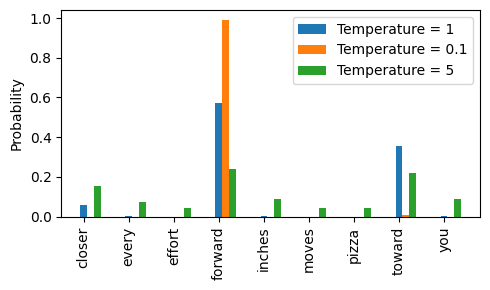

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores.

In other words, using a temperature of 1 is the same as not
using any temperature scaling.

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often.

This can add more variety to the
generated texts but also more often results in nonsensical text.

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.

## **DECODING STRATEGY 2: Top-k sampling**

In the previous section, we implemented a probabilistic sampling approach coupled with
temperature scaling to increase the diversity of the outputs.

We saw that higher
temperature values result in more uniformly distributed next-token probabilities, which
result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting
the most probable token.

This method allows for exploring less likely but potentially more
interesting and creative paths in the generation process.

However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely nonsensical
outputs such as "every effort moves you pizza".

In this section, we introduce another concept called top-k sampling, which, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch's where function to set the logit values of tokens that are
below the lowest logit value within our top-3 selection to negative infinity (-inf).

In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Lastly, let's apply the softmax function to turn these into next-token probabilities:

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## **Merge Temperature Scaling and Top-k sampling**

We can now apply the temperature scaling and multinomial function for probabilistic
sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by
modifying the text generation function.

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and
add these concepts to modify the generate_simple function we used to generate text via
the LLM earlier, creating a new generate function

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

Let's now see this new generate function in action

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


As we can see, the generated text is very different from the one we previously generated
via the generate_simple function at the beginning of section 5.3 ("Every effort moves
you know," was one of the axioms he laid...!"), which was a memorized passage
from the training set.

# **Decoding Strategies in LLMs**


When a **Large Language Model (LLM)** like GPT or LLaMA generates text, it predicts
*“What’s the most likely next word given all previous words?”*
<br>
But there’s a catch
LLMs don’t just output *one* word; they output a **probability distribution** over thousands of possible words (tokens).

Decoding strategies control **how we choose the next word** from those probabilities.

## **What Decoding Really Means**


Imagine this

```
Input: "The cat is"
Predictions:
sleeping → 0.70
running → 0.20
eating  → 0.10
```

Now the model must decide — which one to pick?
Different decoding strategies make this choice differently.

## **Greedy Decoding**

Idea: Always pick the word with the *highest* probability.

Example:

```
sleeping (0.7) → choose “sleeping”
```

> Output: “The cat is sleeping.”

**Pros**

* Simple and very fast
* Always gives the same answer (deterministic)

**Cons**

* Can get repetitive (e.g., “the cat is sleeping sleeping sleeping…”)
* Sometimes misses better long-term options

**Use when:** you want short, factual, or code-like outputs where creativity isn’t needed.


##  **Beam Search**

**Idea:** Keep multiple possible sentences at once — not just one.

Let’s say *beam size = 3*:

* The model keeps the 3 most likely sentence paths at each step.
* It expands them, scores them, and keeps the best 3 again.
* Finally, it chooses the most likely full sentence.

**Example:**

```
Beams:
1. The cat is sleeping.
2. The cat is running fast.
3. The cat is eating fish.
```

→ Model picks the best based on total probability.

**Pros**

* More balanced and accurate than greedy
* Often gives smoother, grammatically correct text

**Cons**

* Slower (because it tries many paths)
* Still may lack creativity
* Can repeat phrases if beam size is too big

**Used in:** translation models (e.g., Google Translate), summarization.

## **Top-k Sampling**

**Idea:** Add controlled randomness.
Instead of picking *only the top token*, choose randomly from the **top k tokens**.

**Example:**
If `k = 3`

```
sleeping (0.7)
running (0.2)
eating  (0.1)
```

→ Model randomly picks one from these 3.

**Pros**

* Adds creativity and variation
* Reduces boring repetitive output

**Cons**

* Still somewhat random
* Needs tuning (too high k = chaos, too low k = boring)

**Used in:** story generation, role-playing chatbots, and poetry generation.

## **Top-p (Nucleus) Sampling**

**Idea:** Instead of a *fixed number* of words (like k), choose tokens until their **total probability ≥ p** (like 0.9).

**Example**

```
sleeping (0.7) + running (0.2) = 0.9 → pick from [sleeping, running]
```

→ Model samples from only these.

**Pros**

* Automatically adapts to context (flexible)
* Produces human-like, natural text

**Cons**

* Can still be inconsistent
* Requires good choice of p (commonly 0.9 or 0.95)

**Used in:** ChatGPT and modern conversational LLMs.

## **Temperature Sampling**

**Idea** Control how “confident” or “creative” the model is by adjusting *temperature (T)*.

* **Low T (< 1.0):** more focused and predictable
* **High T (> 1.0):** more random and creative

**Example**

```
At T = 0.5 → prefers top tokens strongly  
At T = 1.5 → explores more varied words
```

**Pros**

* Fine-tunes creativity vs accuracy
* Works great combined with Top-p or Top-k

**Cons**

* Too high T = nonsense
* Too low T = robotic text

**Used when:** you want to control tone — factual (low T), or creative (high T).

## **Typical Sampling**

**Idea:** Keeps words that are *“typical”* (close to model’s average surprise level).
Removes

* Words that are too common (boring)
* Words that are too rare (weird)

**Pros**

* Natural, balanced, less repetitive text
* Combines the best of Top-p and Temperature

**Used in** modern chatbots like GPT-3.5, GPT-4 for conversational tone.

##  **Contrastive Decoding**

**Idea:** Uses two models

* **Large model:** generates fluent text
* **Small model:** filters out generic or overconfident text

Formula
$$
\text{score}(x) = P_{large}(x) - \alpha \times P_{small}(x)
$$

**Pros**

* More factual and precise
* Avoids hallucinations and repetition

**Used in** factual Q&A, retrieval-based systems, and academic content.


## **Sampling + Re-ranking**

**Idea** Generate multiple possible outputs, then rank them with a *reward* or *critic model* (used in RLHF — Reinforcement Learning from Human Feedback).

Example

1. Generate 5 possible replies.
2. Use a separate model to score them.
3. Choose the one with the best score.

**Pros**

* Highest quality responses
* Aligns with human preferences
**Used in** ChatGPT and alignment training.

## **Quick Analogy**

Think of decoding like **ordering food from a restaurant** 🍽️:

| Strategy             | Analogy                                                                      |
| -------------------- | ---------------------------------------------------------------------------- |
| **Greedy**           | Always order your favorite dish every time.                                  |
| **Beam Search**      | Try 3 dishes, then pick the best one.                                        |
| **Top-k**            | Choose randomly from your top 3 favorites.                                   |
| **Top-p**            | Choose randomly from dishes that together make up 90% of your favorites.     |
| **Temperature**      | Higher temperature → you experiment more; lower temperature → you play safe. |
| **Typical Sampling** | You usually order something “normal” — not too basic, not too weird.         |
| **Contrastive**      | You and your friend (small model) agree on what’s good before ordering.      |


# **LOADING AND SAVING MODEL WEIGHTS IN PYTORCH**

Fortunately, saving a PyTorch model is relatively straightforward.

The recommended way is to save a model's so-called state_dict, a dictionary mapping each layer to its parameters,
using the torch.save function as follows

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In the preceding code, "model.pth" is the filename where the state_dict is saved.

The .pth extension is a convention for PyTorch files, though we could technically use any file
extension.

Then, after saving the model weights via the `state_dict` we can load the model
weights into a new GPTModel model instance as follows

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

If we plan to continue pretraining a model later, for example, using the
train_model_simple function we defined earlier in this chapter, saving the optimizer state
is also recommended.

Adaptive optimizers such as AdamW store additional parameters for each model weight.
AdamW uses historical data to adjust learning rates for each model parameter dynamically.
                                                   
Without it, the optimizer resets, and the model may learn suboptimally or even fail to
converge properly, which means that it will lose the ability to generate coherent text.

Using
torch.save, we can save both the model and optimizer state_dict contents as follows

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

hen, we can restore the model and optimizer states as follows by first loading the saved
data via torch.load and then using the load_state_dict method

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## **LOADING PRETRAINED WEIGHTS FROM OPENAI**

Previously, for educational purposes, we trained a small GPT-2 model using a limited
dataset comprising a short-story book.

This approach allowed us to focus on the
fundamentals without the need for extensive time and computational resources.

    
Fortunately, OpenAI openly shared the weights of their GPT-2 models, thus eliminating
the need to invest tens to hundreds of thousands of dollars in retraining the model on a
large corpus ourselves.

In the remainder of this section, we load these weights into our GPTModel class and use
the model for text generation.

Here, weights refer to the weight parameters that are stored
in the .weight attributes of PyTorch's Linear and Embedding layers, for example.

We accessed them earlier via model.parameters() when training the model.

Note that OpenAI originally saved the GPT-2 weights via TensorFlow, which we have to
install to load the weights in Python.

Moreover, the following code will use a progress bar
tool called tqdm to track the download process, which we also have to install.

In [ ]:
pip install tensorflow>=2.15.0 tqdm>=4.66

zsh:1: 2.15.0 not found
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.16.1
tqdm version: 4.66.2


We download the gpt_download.py Python module directly from this chapter's online repository

We can now import the download_and_load_gpt2 function from the gpt_download.py
file as follows, which will load the GPT-2 architecture settings (settings) and weight
parameters (params) into our Python session

In [ ]:
from gpt_download3 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
model.ckpt.data-00000-of-00001: 100%|████████████| 498M/498M [09:33<00:00, 868kiB/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
model.ckpt.index: 100%|███████████████████████| 5.21k/5.21k [00:00<00:00, 6.57MiB/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/co

After the execution of the previous code has been completed, let's inspect the contents of
settings and params

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


Both settings and params are Python dictionaries. The settings dictionary stores the LLM
architecture settings similarly to our manually defined GPT_CONFIG_124M settings.

The
params dictionary contains the actual weight tensors.

    
Note that we only printed the
dictionary keys because printing the weight contents would take up too much screen space

We can inspect these weight tensors by printing the whole dictionary via
print(params) or by selecting individual tensors via the respective dictionary keys, for
example, the embedding layer weights

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


We downloaded and loaded the weights of the smallest GPT-2 model via the
download_and_load_gpt2(model_size="124M", ...) setting. However, note that OpenAI
also shares the weights of larger models: "355M", "774M", and "1558M".

Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance.

First, we initialize a new GPTModel instance.

Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too.
                                                                                                                                                                                                                                                                                                                                  
We are also using the 1024 token context length that was used by the original GPT-2 model(s)

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


Careful readers may remember that we used a 256-token length earlier, but the original
GPT-2 models from OpenAI were trained with a 1,024-token length, so we have to update
the NEW_CONFIG accordingly

Also, OpenAI used bias vectors in the multi-head attention module's linear layers to
implement the query, key, and value matrix computations.

Bias vectors are not commonly
used in LLMs anymore as they don't improve the modeling performance and are thus
unnecessary.

However, since we are working with pretrained weights, we need to match the
settings for consistency and enable these bias vectors

In [ ]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

By default, the GPTModel instance is initialized with random weights for pretraining.

The last
step to using OpenAI's model weights is to override these random weights with the weights
we loaded into the params dictionary.

For this, we will first define a small assign utility function that checks whether two
tensors or arrays (left and right) have the same dimensions or shape and returns the
right tensor as trainable PyTorch parameters

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Next, we define a load_weights_into_gpt function that loads the weights from the params
dictionary into a GPTModel instance gpt

Step 1: Setting the model's positional and token embedding weights to those specified in params.

Step 2: Iterate over each transformer block in the model.

Step 3: The np.split function is used to divide the attention and bias weights into three equal parts for the query,
key, and value components.
    
Step 4: The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the
total number of parameters, which is a concept known as weight tying.

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In the load_weights_into_gpt function, we carefully match the weights from OpenAI's
implementation with our GPTModel implementation.

To pick a specific example, OpenAI
stored the weight tensor for the output projection layer for the first transformer block as
params["blocks"][0]["attn"]["c_proj"]["w"].
                                                        
In our implementation, this weight
tensor corresponds to gpt.trf_blocks[b].att.out_proj.weight, where gpt is a
GPTModel instance.

Developing the load_weights_into_gpt function took a lot of guesswork since OpenAI
used a slightly different naming convention from ours.

However, the assign function would
alert us if we try to match two tensors with different dimensions.

Also, if we made a
mistake in this function, we would notice this as the resulting GPT model would be unable
to produce coherent text.

<div class="alert alert-block alert-success">

Let's now try the load_weights_into_gpt out in practice and load the OpenAI model
weights into our GPTModel instance gpt:
    
</div>

In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

If the model is loaded correctly, we can now use it to generate new text using our previous
generate function

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




We can be confident that we loaded the model weights correctly because the model can
produce coherent text.

A tiny mistake in this process would cause the model to fail.

    
In the following chapters, we will work further with this pretrained model and fine-tune it
to classify text and follow instructions.

# **FINETUNING FOR CLASSIFICATION**

### **DOWNLOADING DATASET**

In [ ]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


After executing the preceding code, the dataset is saved as a tab-separated text file,
SMSSpamCollection.tsv, in the sms_spam_collection folder.

We can load it into a pandas
DataFrame as follows

In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


When we check the class distribution, we see that the data contains "ham" (i.e., "not spam") much more frequently than "spam"

In [ ]:
print(df["Label"].value_counts())


Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity, and because we prefer a small dataset for educational purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class

In [ ]:
def create_balanced_dataset(df):

    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


After executing the previous code to balance the dataset, we can see that we now have
equal amounts of spam and non-spam messages

Next, we convert the "string" class labels "ham" and "spam" into integer class labels 0 and
1, respectively

In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

This process is similar to converting text into token IDs.

However, instead of using the GPT
vocabulary, which consists of more than 50,000 words, we are dealing with just two token
IDs: 0 and 1.

We create a random_split function to split the dataset into three parts: 70% for
training, 10% for validation, and 20% for testing.

(These ratios are common in machine
learning to train, adjust, and evaluate models.)

In [ ]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


Additionally, we save the dataset as CSV (comma-separated value) files, which we can
reuse later

In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### **CREATING DATALOADERS**

Previously, we utilized a sliding window technique to generate uniformly
sized text chunks, which were then grouped into batches for more efficient model training.
Each chunk functioned as an individual training instance

In the case of email spam classification, have two primary options:

(1) Truncate all messages to the length of the shortest message in the
dataset or batch.

(2) Pad all messages to the length of the longest message in the dataset or
batch.

> Option 1 is computationally cheaper, but it may result in significant information loss if
shorter messages are much smaller than the average or longest messages, potentially
reducing model performance.

So, we opt for the second option, which preserves the entire
content of all messages.

To implement option 2, where all messages are padded to the length of the longest
message in the dataset, we add padding tokens to all shorter messages.

For this purpose,
we use "<|endoftext|>" as a padding token, as discussed in chapter 2.

    
However, instead of appending the string "<|endoftext|>" to each of the text messages
directly, we can add the token ID corresponding to "<|endoftext|>" to the encoded text

As we have seen earlier, we first need to implement a PyTorch Dataset, which
specifies how the data is loaded and processed, before we can instantiate the data loaders.
    

For this purpose, we define the SpamDataset class.

This SpamDataset class handles several key tasks: it identifies the
longest sequence in the training dataset, encodes the text messages, and ensures that all
other sequences are padded with a padding token to match the length of the longest
sequence.

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd  # Required for reading CSV files


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        """
        Custom PyTorch Dataset class for spam detection tasks.

        Args:
            csv_file (str): Path to the CSV file containing 'Text' and 'Label' columns.
            tokenizer (object): Tokenizer used to convert text into token IDs.
            max_length (int, optional): Maximum sequence length for each sample.
                                        If None, it is set to the longest sequence found.
            pad_token_id (int): Token ID used for padding shorter sequences.
        """
        # Load the dataset from a CSV file
        self.data = pd.read_csv(csv_file)

        # Tokenize each text in the dataset and store the tokenized lists
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        # Determine the maximum sequence length
        if max_length is None:
            # Automatically set to the longest tokenized sequence
            self.max_length = self._longest_encoded_length()
        else:
            # Use the user-specified maximum sequence length
            self.max_length = max_length

            # Truncate any sequence longer than the maximum length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad all sequences so they have equal length (self.max_length)
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        """
        Retrieve a single sample from the dataset.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: (input_tensor, label_tensor)
                   - input_tensor: Tensor of token IDs for the text.
                   - label_tensor: Corresponding label (0 for ham, 1 for spam).
        """
        # Get the encoded sequence
        encoded = self.encoded_texts[index]

        # Get the label for the given sample
        label = self.data.iloc[index]["Label"]

        # Convert both encoded text and label into PyTorch tensors
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.data)

    def _longest_encoded_length(self):
        """
        Compute the length of the longest tokenized text in the dataset.

        Returns:
            int: The maximum sequence length among all tokenized samples.
        """
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

Step 1: Pre-tokenize texts
    
Step 2: Truncate sequences if they are longer than max_length
    
Step 3: Pad sequences to the longest sequence

The SpamDataset class loads data from the CSV files we created earlier, tokenizes the text
using the GPT-2 tokenizer from tiktoken and allows us to pad or truncate the sequences to
a uniform length determined by either the longest sequence or a predefined maximum
length.

This ensures each input tensor is of the same size, which is necessary to create the
batches in the training data loader we implement next

In [ ]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


The code outputs 120, showing that the longest sequence contains no more than 120
tokens, a common length for text messages.
                       
It's worth noting that the model can handle
sequences of up to 1,024 tokens, given its context length limit.

If your dataset includes
longer texts, you can pass max_length=1024 when creating the training dataset in the
preceding code to ensure that the data does not exceed the model's supported input
(context) length.

Next, we pad the validation and test sets to match the length of the longest training
sequence.

It's important to note that any validation and test set samples exceeding the
length of the longest training example are truncated using
encoded_text[:self.max_length] in the SpamDataset code we defined earlier.

This
truncation is optional; you could also set max_length=None for both validation and test
sets, provided there are no sequences exceeding 1,024 tokens in these sets

In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


Using the datasets as inputs, we can instantiate the data loaders similarly to what we did earlier.

However, in this case, the targets represent class labels rather than the next
tokens in the text.

For instance, choosing a batch size of 8, each batch will consist of 8
training examples of length 120 and the corresponding class label of each example.

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

To ensure that the data loaders are working and are indeed returning batches of the
expected size, we iterate over the training loader and then print the tensor dimensions of
the last batch

In [ ]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


As we can see, the input batches consist of 8 training examples with 120 tokens each, as
expected.

The label tensor stores the class labels corresponding to the 8 training examples.


<div class="alert alert-block alert-success">

Lastly, to get an idea of the dataset size, let's print the total number of batches in each
dataset:
</div>

In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


This concludes the data preparation. Next, we will prepare the model for
finetuning.

## **INITIALIZING A MODEL WITH PRETRAINED WEIGHTS**

In this section, we prepare the model we will use for the classification-finetuning to identify
spam messages.

We start with initializing the pretrained model we worked with in the
previous chapter

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

Next, we import the download_and_load_gpt function from the gpt_download3.py file we
downloaded earlier.

Furthermore, we also reuse the GPTModel class and
load_weights_into_gpt function from chapter 5 to load the downloaded weights into the
GPT model

In [ ]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

from gpt_download3 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


To ensure that the model was loaded correctly, let's double-check that it generates coherent text

In [ ]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Now, before we start finetuning the model as a spam classifier, let's see if the model can
perhaps already classify spam messages by by prompting it with instructions

In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Based on the output, it's apparent that the model struggles with following instructions.

This is anticipated, as it has undergone only pretraining and lacks instruction-finetuning,
which we will explore in the upcoming chapter

The next section prepares the model for classification-finetuning

## **ADDING A CLASSIFICATION HEAD**

In this section, we modify the pretrained large language model to prepare it for
classification-finetuning.

To do this, we replace the original output layer, which maps the
hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to
two classes: 0 ("not spam") and 1 ("spam"),

We could technically use a single output node since we are dealing with a binary
classification task.

However, this would require modifying the loss function.

Therefore, we choose a
more general approach where the number of output nodes matches the number of
classes.

For example, for a 3-class problem, such as classifying news articles as
"Technology", "Sports", or "Politics", we would use three output nodes, and so forth.

Before we attempt to construct the modified architecture, let's print the model
architecture via print(model), which prints the following

In [ ]:
print(model)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Above, we can see the GPT architecture neatly laid out.

As
discussed earlier, the GPTModel consists of embedding layers followed by 12 identical
transformer blocks (only the last block is shown for brevity), followed by a final LayerNorm
and the output layer, out_head.

Next, we replace the out_head with a new output layer, as illustrated in figure 6.9, that
we will finetune.  

To get the model ready for classification-finetuning, we first freeze the model, meaning that
we make all layers non-trainable

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Then, we replace the output layer (model.out_head), which
originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary)

In [ ]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

Note that in the preceding code, we use BASE_CONFIG["emb_dim"], which is equal to 768 in
the "gpt2-small (124M)" model, to keep the code below more general.

This means we
can also use the same code to work with the larger GPT-2 model variants.

This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.

This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.

Additionally, we configure the last transformer block and the final LayerNorm module,
which connects this block to the output layer, to be trainable

In [ ]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

Even though we added a new output layer and marked certain layers as trainable or nontrainable, we can still use this model in a similar way to previous chapters.

For instance, we
can feed it an example text identical to how we have done it in earlier chapters. For
example, consider the following example text

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


Then, we can pass the encoded token IDs to the model as usual

In [ ]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In earlier chapters, a similar input would have produced an output tensor of [1, 4, 50257],
where 50,257 represents the vocabulary size.

As in previous chapters, the number of
output rows corresponds to the number of input tokens (in this case, 4).

However, each
output's embedding dimension (the number of columns) is now reduced to 2 instead of
50,257 since we replaced the output layer of the model.

Remember that we are interested in finetuning this model so that it returns a class label
that indicates whether a model input is spam or not spam.

To achieve this, we don't need to
finetune all 4 output rows but can focus on a single output token.

In particular, we will
focus on the last row corresponding to the last output token

To extract the last output token, illustrated in figure 6.11, from the output tensor, we
use the following code

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


Having modified the model, the next section will detail the process of transforming the
last token into class label predictions and calculate the model's initial prediction accuracy.

Following this, we will finetune the model for the spam classification task in the subsequent
section.

## **CALCULATING THE CLASSIFICATION LOSS AND ACCURACY**

So far in this chapter, we have prepared the dataset, loaded a pretrained model, and
modified it for classification-finetuning.
           
Before we proceed with the finetuning itself, only
one small part remains: implementing the model evaluation functions used during
finetuning,  

Before implementing the evaluation utilities, let's briefly discuss how we convert the model
outputs into class label predictions.

In the previous chapter, we computed the token ID of the next token generated by the
LLM by converting the 50,257 outputs into probabilities via the softmax function and then
returning the position of the highest probability via the argmax function.

In this chapter, we
take the same approach to calculate whether the model outputs a "spam" or "not spam"
prediction for a given input, with the only difference being that we
work with 2-dimensional instead of 50,257-dimensional outputs.

Let's consider the last token output from
the previous section

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


We can obtain the class label via the following code

In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In this case, the code returns 1, meaning the model predicts that the input text is "spam."

Using the softmax function here is optional because the largest outputs directly correspond
to the highest probability scores.

Hence, we can simplify the
code as follows, without using softmax

In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


his concept can be used to compute the so-called classification accuracy, which measures
the percentage of correct predictions across a dataset.

to determine the classification accuracy, we apply the argmax-based prediction code to
all examples in the dataset and calculate the proportion of correct predictions by defining a
calc_accuracy_loader function

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    Calculate the accuracy of a model on data provided by a DataLoader.

    Args:
        data_loader (torch.utils.data.DataLoader): DataLoader containing input and target batches.
        model (torch.nn.Module): Trained model to evaluate.
        device (torch.device): Device to run the model on ('cpu' or 'cuda').
        num_batches (int, optional): Number of batches to evaluate.
                                     If None, all batches are used.

    Returns:
        float: Accuracy of the model on the given data (range: 0.0 to 1.0).
    """

    # Set the model to evaluation mode — disables dropout, batchnorm updates, etc.
    model.eval()

    # Initialize counters for correct predictions and total samples
    correct_predictions, num_examples = 0, 0

    # Determine how many batches to iterate through
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        # Ensure we don't exceed total available batches
        num_batches = min(num_batches, len(data_loader))

    # Iterate through the DataLoader
    for i, (input_batch, target_batch) in enumerate(data_loader):

        # Process only the specified number of batches
        if i < num_batches:
            # Move input and target tensors to the appropriate device
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # Disable gradient calculations for faster evaluation
            with torch.no_grad():
                # Forward pass through the model
                # Extract logits (model outputs before softmax)
                # [:, -1, :] means we take the logits of the last token (useful in autoregressive models)
                logits = model(input_batch)[:, -1, :]

            # Get the predicted label (index of max logit value)
            predicted_labels = torch.argmax(logits, dim=-1)

            # Update counters
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            # Stop if we've reached the desired number of batches
            break

    # Compute and return the accuracy
    return correct_predictions / num_examples

Let's use the function to determine the classification accuracies across various datasets
estimated from 10 batches for efficiency

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


As we can see, the prediction accuracies are near a random prediction, which would be
50% in this case.

To improve the prediction accuracies, we need to finetune the model.

Classification accuracy is not a differentiable function, so we use cross entropy
loss as a proxy to maximize accuracy.

This is the same cross entropy loss discussed earlier.

Accordingly, the calc_loss_batch function remains the same as in earlier, with one
adjustment: we focus on optimizing only the last token, model(input_batch)[:, -1, :],
rather than all tokens, model(input_batch)

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

We use the calc_loss_batch function to compute the loss for a single batch obtained from
the previously defined data loaders. To calculate the loss for all batches in a data loader, we
define the calc_loss_loader function

In [ ]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

Similar to calculating the training accuracy, we now compute the initial loss for each
data set

In [ ]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In the next section, we will implement a training function to finetune the model, which
means adjusting the model to minimize the training set loss.

Minimizing the training set
loss will help increase the classification accuracy, our overall goal

## **FINETUNING THE MODEL ON SUPERVISED DATA**

In this section, we define and use the training function to finetune the pretrained LLM and
improve its spam classification accuracy.
    
The training loop is the
same overall training loop we used earlier, with the only difference being that we
calculate the classification accuracy instead of generating a sample text for evaluating the
model.

The training function also closely mirrors
the train_model_simple function used for pretraining the model earlier.
                                    
The only two distinctions are that we now track the number of training examples seen
(examples_seen) instead of the number of tokens, and we calculate the accuracy after each
epoch instead of printing a sample text

  
Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

In [ ]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

The evaluate_model function used in the train_classifier_simple is the same as the one we used earlier.

In [ ]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

Next, we initialize the optimizer, set the number of training epochs, and initiate the training
using the train_classifier_simple function.

We will discuss the choice of the the number
of training epochs after we evaluated the results.

The training takes about 6 minutes on an
M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 8.83 mi

We then use matplotlib to plot the loss function for the training and
validation set

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

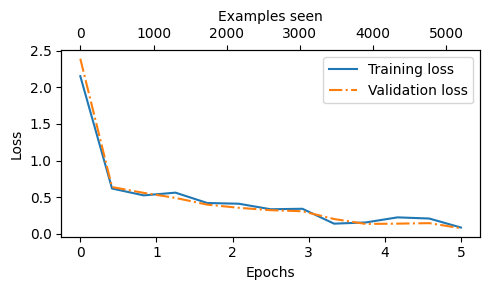

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see based on the sharp downward slope, the model is learning well
from the training data, and there is little to no indication of overfitting; that is, there is no
noticeable gap between the training and validation set losses).

Using the same plot_values function, let's now also plot the classification accuracies

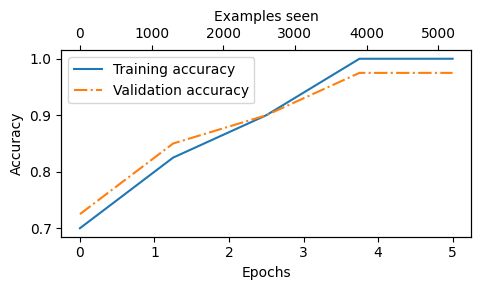

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Based on the accuracy plot in figure , the model achieves a relatively high training and
validation accuracy after epochs 4 and 5.
    
However, it's important to note that we previously set eval_iter=5 when using the
train_classifier_simple function, which means our estimations of training and
validation performance were based on only 5 batches for efficiency during training.

Now, we will calculate the performance metrics for the training, validation, and test sets
across the entire dataset by running the following code, this time without defining the
eval_iter value

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


The training and test set performances are almost identical.

A slight discrepancy between the training and test set accuracies suggests minimal
overfitting of the training data.

Typically, the validation set accuracy is somewhat higher
than the test set accuracy because the model development often involves tuning
hyperparameters to perform well on the validation set, which might not generalize as
effectively to the test set.

This situation is common, but the gap could potentially be minimized by adjusting the
model's settings, such as increasing the dropout rate (drop_rate) or the weight_decay
parameter in the optimizer configuration.

## **USING THE LLM AS A SPAM CLASSIFIER**

After finetuning and evaluating the model in the previous sections, we are now in the final
stage of this chapter:  using the model to classify spam
messages.

Finally, let's use the finetuned GPT-based spam classification model.

The following
`classify_review function` follows data preprocessing steps similar to those we used in the
SpamDataset implemented earlier in this chapter.

And then, after processing text into token
IDs, the function uses the model to predict an integer class label, similar to what we have
implemented earlier, and then returns the corresponding class name

Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

Let's try this classify_review function on an example text

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


The resulting model correctly predicts "spam".

In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


Also, here, the model makes a correct prediction and returns a "not spam" label

Finally, let's save the model in case we want to reuse the model later without having to
train it again using the torch.save method

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")


Once saved, the model can be loaded as follows

In [ ]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# **INSTRUCTION FINE-TUNING**

## **STEP 1: PREPARING DATASET**

In this section, we download and format the instruction dataset for instruction finetuning a
pretrained LLM in this chapter. The dataset consists of 1100 instruction-response pairs.

The following code implements and executes a function to download this dataset, which
is a relatively small file, only 204 KB in size, in JSON format. JSON, or JavaScript Object
Notation, mirrors the structure of Python dictionaries, providing a simple structure for data
interchange that is both human-readable and machine-friendly.

In [ ]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


The data list , which we loaded from the JSON file contains the 1100 entries of the
instruction dataset.

Let's print one of the entries to see how each entry is structured

In [ ]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [ ]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### **CONVERTING INSTRUCTIONS INTO ALPACA FORMAT**

In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

This format_input function takes a dictionary entry as input and constructs a formatted
string.

Let's test it to dataset entry data[50], which to looked at earlier

In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


Note that the format_input skips the optional ### Input: section if the 'input' field is
empty, which we can test out by applying the format_input function to entry data[999]
that we inspected earlier

In [ ]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


### **SPLITTING DATASET INTO TRAIN-TEST-VALIDATION**

In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


Having successfully downloaded and partitioned the dataset, and gained a clear
understanding of the dataset prompt formatting, we are now ready for the core
implementation of the instruction finetuning process

## **STEP 2: ORGANIZING DATA INTO TRAINING BATCHES**

In the previous chapter, the training batches were created automatically by the PyTorch
DataLoader class, which employs a default collate function to combine lists of samples into
batches.

A collate function is responsible for taking a list of individual data samples and
merging them into a single batch that can be processed efficiently by the model during
training.

However, the batching process for instruction finetuning in this chapter is a bit more
involved and requires us to create our own custom collate function that we will later plug
into the DataLoader.

We implement this custom collate function to handle the specific
requirements and formatting of our instruction finetuning dataset.

First, we code an
InstructionDataset class that applies format_input from the previous section and pretokenizes all inputs in the dataset, similar to the SpamDataset in chapter 6.

In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

Similar to the approach in chapter 6, we aim to accelerate training by collecting multiple
training examples in a batch, which necessitates padding all inputs to a similar length.

As with the previous chapter, we use the <|endoftext|> token as a padding token.
    
Instead of appending the <|endoftext|> tokens to the text inputs, we can append its
token ID to the pre-tokenized inputs directly.

To remind us which token ID we should use,
we can use the tokenizer's .encode method on an <|endoftext|> token:

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In previuosly, we padded all examples in a dataset to the same length.

Moving on, here, we adopt a more sophisticated approach by developing a custom
collate function that we can pass to the data loader.

This custom collate function pads the
training examples in each batch to have the same length, while allowing different batches
to have different lengths.

This approach minimizes unnecessary
padding by only extending sequences to match the longest one in each batch, not the
whole dataset.

We can implement the padding process with a custom collate
function as follows

Step 1: Find the longest sequence in the batch
    
Step 2: Pad and prepare inputs
    
Step 3: Remove extra padded token added earlier

Step 4: Convert list of inputs to tensor and transfer to target device

In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

The custom_collate_draft_1 we implemented is designed to be integrated into a PyTorch
DataLoader, but it can also function as a standalone tool.

Here, we use it independently to
test and verify that it operates as intended.

Let's try it on three different inputs that we
want to assemble into a batch, where each example gets padded to the same length


In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


As we can see based on the preceding output, all inputs have been padded to the length of
the longest input list, inputs_1 containing 5 token IDs.

So far, we have just implemented our first custom collate function to create batches from
lists of inputs.

However, as you learned in previous lessons, we also need to create batches
with the target token IDs, corresponding to the batch of input IDs.

These target IDs are crucial because they represent what we want the model to
generate and what we need during training to calculate the loss for the weight updates,
similar to previous chapters.

#### **CREATING TARGET TOKEN IDS FOR TRAINING**

Similar to the process described for pretraining an LLM, the target token IDs
match the input token IDs but are shifted one position to the right.

This setup allows the LLM to learn how to predict the next token in a sequence.

The following updated collate function generates the target token IDs from the input token IDs

In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

Step 1: Truncate the last token for inputs
                               
Step 2: Shift +1 to the right for targets

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


The 1st tensor represents inputs.
    
The 2nd tensor represents the targets

In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contributing to
the training loss calculation, ensuring that only meaningful data influences model learning.

In classification fine-tuning, we did not have to worry about this since we only trained the model based on
the last output token.)

Note that we retain one end-of-text token, ID 50256, in the target list.

This allows the LLM to learn when to generate an end-of-text token
in response to instructions, which we use as an indicator that the generated response is
complete.

In the following code, we modify our custom collate function to replace tokens with ID
50256 with -100 in the target lists.

Additionally, we introduce
an allowed_max_length parameter to optionally limit the length of the samples.

This
adjustment will be useful if you plan to work with your own datasets that exceed the 1024-
token context size supported by the GPT-2 model.

The code for this updated collate function
is as follows

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

Step 1: Replace all but the first padding tokens in targets by ignore_index

Step 2: Optionally truncate to maximum sequence length

Again, let's try the collate function on the sample batch that we created earlier to check
that it works as intended

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


The modified collate function works as expected, altering the target list by inserting the
token ID -100.

What is the logic behind this adjustment? Let's explore the underlying
purpose of this modification.

For demonstration purposes, consider the following simple and self-contained example
where each output logit can correspond to a potential token from the model's vocabulary.

Here's how we might calculate the cross entropy loss (introduced in chapter 5) during
training when the model predicts a sequence of tokens, similar to what we have done in
chapter 5 when pretraining the model, or in chapter 6 when finetuning the model for
classification

In [ ]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


Adding an additional token ID will, as we would expect, affect the loss calculation.

In [ ]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


Now, let's get to the interesting part and see what happens if we replace the third target
token ID with -100

In [ ]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)

targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


Based on this result, we can see that the resulting loss on these 3 training examples is
identical to the loss we calculated from the 2 training examples earlier.

In other words, the
cross entropy loss function ignored the third entry in the targets_3 vector, the token ID
corresponding to -100.

(Interested readers can try to replace the -100 value with another
token IDs that is not 0 or 1, and will see that this results in an error.)

So, what's so special about -100 that it's ignored by the cross entropy loss? The default
setting of the cross entropy function in PyTorch is cross_entropy(...,
ignore_index=-100).

This means that it ignores targets labeled with -100.

In this chapter, we take advantage of this ignore_index to ignore the additional end-oftext (padding) tokens that we used to pad the training examples to have the same length in
each batch.

However, we want to keep one 50256 (end-of-text)
token ID in the targets because it helps the LLM to learn to generate end-of-text tokens,
which we can use as an indicator that a response is complete.

#### **MASKING TARGET TOKEN IDS**

In addition to masking out padding tokens, it is also common to mask out the target
token IDs that correspond to the instruction

By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the generated response target
IDs.

By masking out the instruction tokens, the model is trained to focus on generating
accurate responses rather than additionally also memorizing instructions, which can help
with reducing overfitting.


Currently, researchers are divided on whether masking the instructions is universally beneficial during instruction finetuning.

For instance, a recent
paper titled "Instruction Tuning With Loss Over Instructions" demonstrated that not
masking the instructions benefits the LLM performance.

In this chapter, we do not apply masking and leave it as an optional
exercise for the reader.

## **STEP 3: CREATING DATALOADERS FOR AN INSTRUCTION DATASET**

The custom_collate_fn includes code to move the input and target tensors (for
example, torch.stack(inputs_lst).to(device)) to a specified device, which can be
either "cpu" or "cuda" (for GPUs), or optionally "mps" for Macs with Apple Silicon chips.


In previous chapters, we moved the data onto the target device (for example, the GPU
memory when device="cuda") in the main training loop. Having this as part of the collate
function offers the advantage of performing this device transfer process as a background
process outside the training loop, preventing it from blocking the GPU during model
training.

The following code initializes the device variable

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cpu


Next, to reuse the chosen device setting in custom_collate_fn when we plug it into the
PyTorch DataLoader class later in this section, we use the partial function from Python's
functools standard library to create a new version of the function with the device
argument pre-filled.

Additionally, we set the allowed_max_length to 1024, which truncates
the data to the maximum context length supported by the GPT-2 model we finetune later in
this chapter:


In [ ]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

Next, we can set up the data loaders as we did in previous chapters, but this time we will
use our custom collate function for the batching process

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

Let's examine the dimensions of the input and target batches generated by the training
loader

In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In the preceding output, we can see that the first input and target batch have dimensions
8×61, where 8 represents the batch size, and 61 is the number of tokens in each training
example in this batch.

The second input and target batch have a different number of
tokens, for instance, 76.


As we saw in the preceding code output, thanks to our custom collate function, the data
loader is able to create batches of different lengths.

In the next section, we load a
pretrained LLM that we can then finetune with this data loader.

## **STEP 4: LOADING A PRETRAINED LLM**

Before beginning instruction finetuning, we first load a pretrained GPT model,

Instead of using the smallest 124 million
parameter model as before, we load the medium-sized model with 355 million parameters.

The reason for this choice is that the 124 million parameter model is too limited in capacity
to achieve qualitatively satisfactory results via instruction finetuning.


This is done using the same code as in section 5.5 of chapter 5 and section 6.4 of
the previous chapter, except that we now specify "gpt2-medium (355M)" instead of "gpt2-small
(124M)".

Please note that executing the code provided below will initiate the download of
the medium-sized GPT model, which has a storage requirement of approximately 1.42
gigabytes.

This is roughly three times larger than the storage space needed for the small
model

In [ ]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.index


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.meta


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/vocab.bpe


Before diving into finetuning the model in the next section, let's take a moment to assess
the pretrained LLM's performance on one of the validation tasks by comparing its output to
the expected response.

This will give us a baseline understanding of how well the model
performs on an instruction-following task right out of the box, prior to finetuning, and will
help us appreciate the impact of finetuning later on.

We use the first example from the
validation set for this assessment

In [ ]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

It's important to note that the generate function returns the combined input and output
text.

This behavior was convenient in previous chapters since pretrained LLMs are primarily
designed as text-completion models, where the input and output are concatenated to
create a coherent and legible text.

However, when evaluating the model's performance on a
specific task, we often want to focus solely on the model's generated response.

To isolate the model's response text, we need to subtract the length of the input
instruction from the start of the `generated_text`

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


This code snippet removes the input text from the beginning of the generated_text,
leaving us with only the model's generated response. The strip() function is then applied
to remove any leading or trailing whitespace characters. The output is as follows

As we can see from the output, the pretrained model is not yet capable of correctly
following the given instruction.

While it does create a "Response" section, it simply repeats
the original input sentence and part of the instruction, failing to convert the active sentence
to passive voice as requested.


In the upcoming section, we implement the finetuning process to improve the model's
ability to comprehend and appropriately respond to such requests.

## **STEP 5: FINETUNING THE LLM ON INSTRUCTION DATA**

We already did all the hard work when we implemented the
instruction dataset processing at the beginning of this chapter.

For the finetuning process
itself, we can reuse the loss calculation and training functions implemented in chapter 5
during the pretraining

Before we begin training, let's calculate the initial loss for the training and validation sets

#### **PREVIOUSLY DEFINED FUNCTIONS WHICH WE WILL REQUIRE**

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8258946418762205
Validation loss: 3.7619189739227297


With the model and data loaders prepared, we can now proceed to train the model.

The following code sets up the training process, including initializing the optimizer, setting the
number of epochs, and defining the evaluation frequency and starting context to evaluate
generated LLM responses during training based on the first validation set instruction
(val_data[0]) we looked at earlier

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values.
    
Furthermore, based on the response text printed after each epoch, we can see that the model almost correctly follows the instruction to convert the input sentence 'The chef cooks the meal every day.' into passive voice 'The meal is prepared every day by the chef.' (We will properly format and evaluate the responses in a later section.

To get better results, we need to finetune the model for more epochs.

Finally, let's take a look at the training and validation loss curves

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

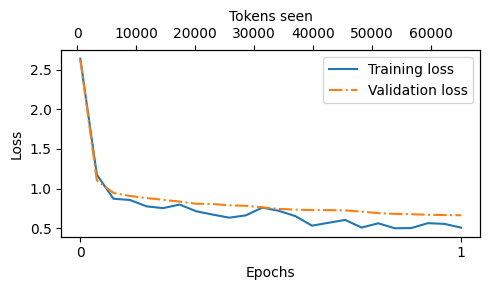

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

As we can see in the loss plot shown above, the model's performance on both the
training and validation sets improves substantially over the course of training.

The rapid
decrease in losses during the initial phase indicates that the model is quickly learning
meaningful patterns and representations from the data. Then, as training progresses to the
second epoch, the losses continue to decrease but at a slower rate, suggesting that the
model is finetuning its learned representations and converging to a stable solution.


While the loss plot in figure 7.17 indicates that the model is training effectively, the most
crucial aspect is its performance in terms of response quality and correctness. In the
remaining sections of this chapter, we will extract the responses and store them in a format
that allows us to evaluate and quantify the response quality.

## **STEP 6: EXTRACTING AND SAVING RESPONSES**

After finetuning the LLM on the training portion of the instruction dataset as described in
the previous section, we now proceed to evaluate its performance on the held-out test set.
    
To accomplish this, we first extract the model-generated responses for each input in the
test dataset and collect them for manual analysis

Step 1: Iterate over the first 3 test set samples

Step 2:  Use the generate function defined earlier

As mentioned earlier, the generate function returns the combined input and output text, so
we use slicing and the .replace() method on the generated_text contents to extract the
model's response.

The instructions, followed by the given test set response and model
response are shown below

In [ ]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere over a region of high pressure. It typically produces a strong wind that blows across the area, creating a dense, dense cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruc

As we can see based on the test set instructions, given responses, and the model's
responses, the model performs relatively well.

The answers to the first instruction
is clearly correct, while the second answer and the third answers are not correct.

This is because we have done the fine-tuning for only 1 epoch due to hardware limitations. To get better results, we need to increase the epochs to at least 2.


Most importantly, we can see that model evaluation is not as straightforward as in the
previous chapter, where we simply calculated the percentage of correct spam/non-spam
class labels to obtain the classification accuracy.

In practice, instruction-finetuned LLMs
such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple choice benchmarks such as MMLU ("Measuring
Massive Multitask Language Understanding," https://arxiv.org/abs/2009.
03300), which test the general knowledge of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot
arena (https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval (https://tatsulab.github.io/alpaca_eval/).
completes the request.

Considering the scale of the task at hand, we will implement an approach similar to
method 3, which involves evaluating the responses automatically using another LLM.

This
will allow us to efficiently assess the quality of the generated responses without the need
for extensive human involvement, thereby saving time and resources while still obtaining
meaningful performance indicators.

To prepare the responses for this evaluation process, we append the generated model
responses to the test_set dictionary and save the updated data as an "instructiondata-with-response.json" file for record keeping.

Additionally, by saving this file, we can
easily load and analyze the responses in separate Python sessions later on if needed.

The following code uses the generate method in the same manner as before; however,
we now iterate over the entire test_set.

Also, instead of printing the model responses, we
add them to the test_set dictionary

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [18:28<00:00, 10.08s/it]


Let's verify that the responses have been correctly added to the test_set dictionary by
examining one of the entries

In [ ]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


Based on the output, we can see that the `model_response` has been added correctly.


Finally, we save the model as gpt2-medium355M-sft.pth file to be able to reuse it in future
projects

In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## **STEP 7: EVALUATING THE FINE-TUNED LLM**

Previously, we judged the performance of an instruction finetuned model by looking at its
responses on 3 examples of the test set.

While this gives us a rough idea of how well the
model performs, this method does not really scale well to larger amounts of responses.

So, in this section, we implement a method to automate the response evaluation of the finetuned LLM using another, larger LLM.

To implement the evaluation step which involves evaluating test set responses in
an automated fashion, we utilize an existing instruction-finetuned 8 billion parameter Llama
3 model developed by Meta AI.

This model can be run locally using the open-source Ollama
application (https://ollama.com).

Ollama is an efficient application for running LLMs on a laptop.

It serves as a wrapper
around the open-source llama.cpp library (https://github.com/ggerganov/llama.cpp), which
implements LLMs in pure C/C++ to maximize efficiency.

However, note that Ollama is only
a tool for generating text using LLMs (inference) and does not support training or finetuning
LLMs.

The following code verifies that the Ollama session is running properly before we use
Ollama to evaluate the test set responses generated in the previous section

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


An alternative to the ollama run command for interacting with the model is through its
REST API using Python.

The following query_model function demonstrates how to use the
API:

Step 1: Create the data payload as a dictionary
    
Step 2: Convert the dictionary to a JSON formatted string and encode it to bytes
    
Step 3: Create a request object, setting the method to POST and adding necessary headers
    
Step 4: Send the request and capture the response

In [ ]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

Before running the subsequent code cells in this notebook, ensure that Ollama is still
running. The previous code cells should print "Ollama running: True" to confirm that the
model is active and ready to receive requests

Here's an example of how to use the `query_llama` function we just implemented

In [ ]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

Using the query_model function defined earlier, we can evaluate the responses generated
by our finetuned model with a prompt that prompts the Llama 3 model to rate our
finetuned model's responses on a scale from 0 to 100 based on the given test set response
as reference.

First, we apply this approach to the first three examples from the test set that we
examined in a previous section

In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

Based on the generated responses, we can observe that the Llama 3 model provides
reasonable evaluations and is capable of assigning partial points when a model's answer is
not entirely correct.

The previous prompt returns highly detailed evaluations in addition to the score.

We can
modify the prompt to just generate integer scores ranging from 0 to 100, where 100
represents the best possible score.

This modification allows us to calculate an average score
for our model, which serves as a more concise and quantitative assessment of its
performance.

The following generate_model_scores function uses a modified the prompt telling the
model to "Respond with the integer number only."

In [ ]:
for entry in test_data[:2]:
    prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
    score = query_model(prompt, model)
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, model))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> 85

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere over a region of high pressure. It typically produces a strong wind that blows across the area, creating a dense, dense cloud.

Score:
>> 20

-------------------------


In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

I am not running the above function because of hardware limitations. I am using a Macbook Air 2020.

It takes about 1 min  on a M3 Macbook Air.

When you run the above code, you will see that the evaluation output shows that our finetuned model achieves an average score above 50,
which provides a useful benchmark for comparison against other models or for
experimenting with different training configurations to improve the model's performance.

It's worth noting that Ollama is not entirely deterministic at the time of this writing,
which means that the scores you obtain might slightly vary from the ones presented above.
    
To obtain more robust results, you can repeat the evaluation multiple times and average
the resulting scores.

To further improve our model's performance, we can explore various strategies, such as:

(1) Adjusting the hyperparameters during finetuning, such as the learning
rate, batch size, or number of epochs.


(2) Increasing the size of the training dataset or diversifying the examples to
cover a broader range of topics and styles.


(3) Experimenting with different prompts or instruction formats to guide the
model's responses more effectively.


(4) Considering the use of a larger pretrained model, which may have greater
capacity to capture complex patterns and generate more accurate
responses.

(5) We can also use parameter efficient fine-tuning techniques like LoRA.
